In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses
from scipy.misc import toimage
import matplotlib.pyplot as plt
import glob
import imageio
import PIL
import time
from IPython import display

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
z_dim = 100
epochs = 60
BATCH_SIZE = 256
BUFFER_SIZE = 60000
learning_rate = 1e-4
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, z_dim])

In [3]:
(train_images,train_labels),(test_images,test_labels) = keras.datasets.mnist.load_data()
train_images = np.concatenate((train_images,test_images))
train_labels = np.concatenate((train_labels,test_labels))
print(train_images.shape,train_labels.shape)
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(70000, 28, 28) (70000,)


In [4]:
class Generator(keras.Model):
    def __init__(self):
        super(Generator,self).__init__()
        self.dense1 = layers.Dense(7*7*256,use_bias=False,input_shape=(100,))
        self.bn1 = layers.BatchNormalization()
        self.reshape = layers.Reshape((7,7,256))
        self.conv2 = layers.Conv2DTranspose(filters=128,kernel_size=5,strides=1,padding='same',use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2DTranspose(filters=64,kernel_size=5,strides=2,padding='same',use_bias=False)
        self.bn3 = layers.BatchNormalization()
        self.conv4 = layers.Conv2DTranspose(filters=1,kernel_size=5,strides=2,padding='same',use_bias=False)
        return
        
    def call(self,inputs,training=None):
        x = tf.nn.leaky_relu(self.bn1(self.dense1(inputs)))
        x = self.reshape(x)
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x),training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x),training=training))
        x = tf.tanh(self.conv4(x))
        return x

In [5]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1 = keras.layers.Conv2D(filters=64,kernel_size=5,strides=2,padding='same',input_shape=[28,28,1])
        self.drop1 = layers.Dropout(0.3)
        self.conv2 = keras.layers.Conv2D(filters=128,kernel_size=5,strides=2,padding='same')
        self.drop2 = layers.Dropout(0.3)
        self.flatten4 = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(1)
        return
        
    def call(self,inputs,training=None):
        x = tf.nn.leaky_relu(self.conv1(inputs))
        x = self.drop1(x,training=training)
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.drop2(x,training=training)
        x = self.dense4(self.flatten4(x))
        return x

In [6]:
generator = Generator()
generator.build(input_shape=(BATCH_SIZE,z_dim))
generator.summary()
discriminator = Discriminator()
discriminator.build(input_shape=(BATCH_SIZE,28,28,1))
discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1254400   
_________________________________________________________________
batch_normalization (BatchNo multiple                  50176     
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  819200    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  204800    
_________________________________________________________________
batch_normalization_2 (Batch multiple                  25

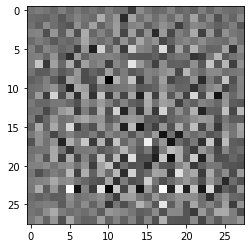

In [7]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [8]:
decision = discriminator(generated_image)
print(decision.numpy())

[[-0.00012422]]


In [9]:
def celoss_ones(logits,smooth=0.0):
    return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(logits)-smooth,logits))

def celoss_zeros(logits,smooth=0.0):
    return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(logits)+smooth,logits))

def discriminator_loss(real_logits,fake_logits):
    real_loss = celoss_ones(real_logits,smooth=0.1)
    fake_loss = celoss_zeros(fake_logits,smooth=0.0)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_logits):
    loss = celoss_ones(fake_logits,smooth=0.1)
    return loss

In [10]:
disc_optimizer = optimizers.Adam(learning_rate=learning_rate)
gen_optimizer = optimizers.Adam(learning_rate=learning_rate)

In [11]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input,training=False)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [13]:
@tf.function
def train_step(real_image):
    noise = tf.random.normal([BATCH_SIZE,z_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_image = generator(noise,training=True)
        real_logits = discriminator(real_image,training=True)
        fake_logits = discriminator(fake_image,training=True)
        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits,fake_logits)
    gen_grads = gen_tape.gradient(gen_loss,generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads,generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads,discriminator.trainable_variables))

In [14]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        if (epoch+1)%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

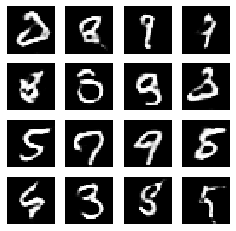

CPU times: user 3min 40s, sys: 11.9 s, total: 3min 52s
Wall time: 11min 18s


In [15]:
%%time
train(train_dataset, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [16]:
def display_image(epoch_no):
    return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))

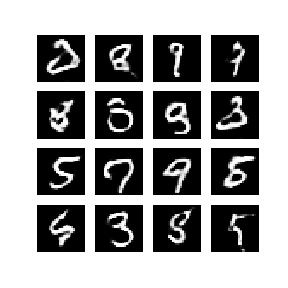

In [17]:
display_image(epochs)

In [18]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)